# Import libraries and data

In [1]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [2]:
# Tesorflow
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image as keras_image

# General
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras import layers, losses

import pickle
import glob
import cv2

In [3]:
# Read images from folder
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # le.classes_
folders = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

X_init = []
y_init = []

for folder in folders:
    path = 'data\\' + folder + '\\*.jpg'
    files = glob.glob(path)

    for file in files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_init.append(img)
        y_init.append(folder)
print('Count of images:', len(X_init))

Count of images: 2251


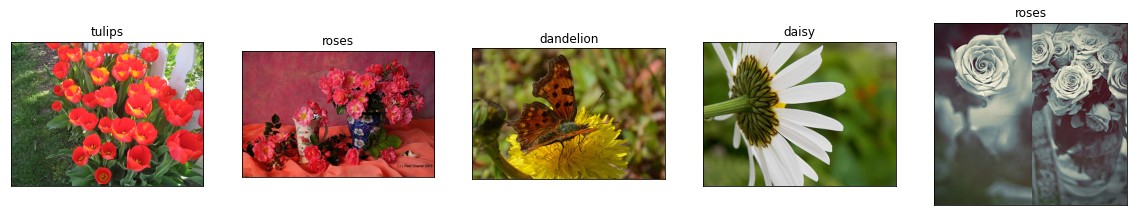

In [4]:
# Choose random 5 images and plot them
def plot_sample(X, y, is_gray = False):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    idxs = np.random.randint(0, len(X), size=5)

    for i, idx in enumerate(idxs):
        img = X[idx]
        ax = axs[i]
        if is_gray:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        label = ""
        if isinstance(y, list):
            label = y[idx]
        else:
            label = CLASS_NAMES[y[idx].argmax()]
        ax.set_title(label)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plot_sample(X_init, y_init)

# Prepocessing data and splitting dataset
Main steps in this section are:
- Convert a label column into several columns using one-hot encoder
- Resize and normalize images
- Augment images by rotation, shearing, flipping

In [5]:
# Convert label column into 5 one hot columns
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y_init).reshape(-1, 1)
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
y_one_hot = enc.fit_transform(y_encoded)
y = np.array(y_one_hot.toarray())

In [6]:
DIM = (128, 128)
# Resize and normalize images
def preprocess(X_init):
    X = []
    for i in range(len(X_init)):
        img = X_init[i].copy()
        img = cv2.resize(img, DIM, interpolation = cv2.INTER_AREA)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = img / 255.0
        img = img.astype('float32')
        X.append(img)
    return X

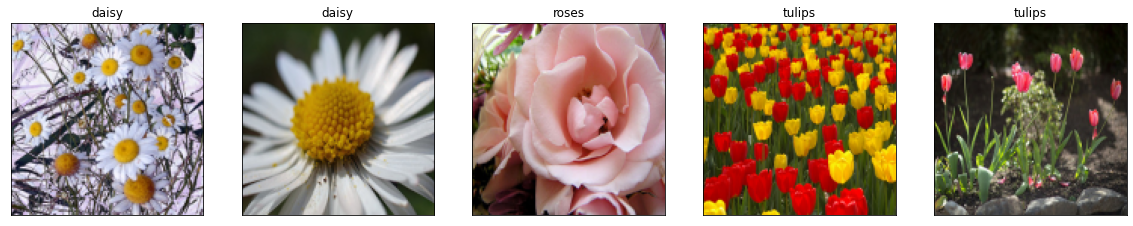

In [7]:
X = preprocess(X_init)
X = np.array(X)
plot_sample(X, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0) # split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0) # split data
print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 1822
Val size: 203
Test size: 226


In [9]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)
aug_iter = data_generator.flow(X_train, y_train)

In [10]:
X_train_aug = []
y_train_aug = []
for i in range(len(aug_iter)):
    it = next(aug_iter)
    for idx in range(it[0].shape[0]):
        X_train_aug.append(it[0][idx])
        y_train_aug.append(it[1][idx])
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)
print(X_train_aug.shape)
print(y_train_aug.shape)

(1822, 128, 128, 3)
(1822, 5)


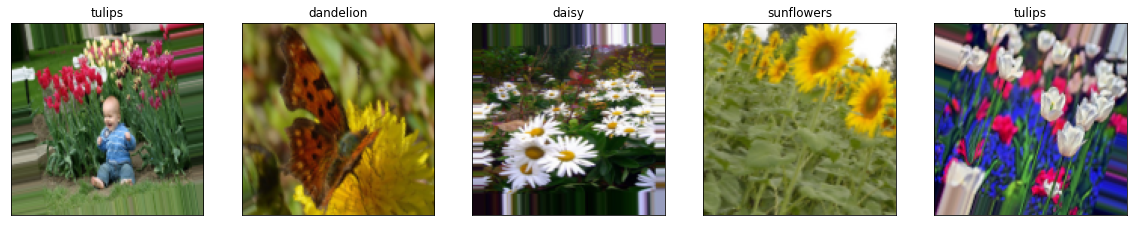

In [11]:
plot_sample(X_train_aug, y_train_aug)

# Models

## Utilities & Consts

In [12]:
BATCH_SIZE = 64
EPOCHS = 20
CLASS_NUM = 5
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [13]:
def show_confusion_matrix(y_test, y_pred, in_prob = True, labels = [], ax = None):
    # y_test & y_pred should be in the same format
    # in_prob == False implies that we get something like [2, 2, 3, 0, ...] where 2, 2... are numbers of class
    # in_prob = True implies that models might give probabilities therefore we need to extract the most possible class
    if(in_prob):
        y_pred = np.argmax(y_pred, axis=1).T
        y_test = np.argmax(y_test, axis=1).T
        
    cf_matrix = confusion_matrix(y_test, y_pred)
    if(ax is None):
        fig, ax = plt.subplots(1, 1, figsize=(16, 4))
        
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.2f', square=True, ax=ax)
    
    if len(labels) != 0:
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
    ax.set_title("Confusion matrix")
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

# Example
#show_confusion_matrix(y_test, y_pred, True, labels = CLASS_NAMES)

In [14]:
def train_save_evaluate(model_func, path, X_train, y_train, X_val, y_val, X_test, y_test, show_summary = True):
    model = model_func()
    if show_summary:
        model.summary()
    
    # train
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))
    
    # evaluate
    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    ax = axs[0]
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')

    ax = axs[1]
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    
    ax = axs[2]
    y_pred = model.predict(X_test)
    show_confusion_matrix(y_test, y_pred, True, labels = CLASS_NAMES, ax=ax)
    
    eval = model.evaluate(X_test, y_test)
    print("Loss: " + str(eval[0]) + " Accuracy: " + str(eval[1]))
    y_pred = np.argmax(y_pred, axis=1).T
    y_test2 = np.argmax(y_test, axis=1).T
    print(classification_report(y_test2, y_pred, target_names=CLASS_NAMES))
    
    # save
    model.save(path)
    model = tf.keras.models.load_model(path)
    
    return model

# inference mehod for CNN models
def inference_cnn(model, imgs):
    pred = []
    dim = (128, 128)
    for img in imgs:
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        img = img / 255
        img = np.expand_dims(img, axis=0)
        pred.append(model.predict(img))
    pred = np.array(pred)
    pred = pred.reshape(len(imgs), 5)
    return pred

# Example of using inference method
def plot_inference(inference_func, model, imgs, y_test, cols = 5, with_prob = False):
    y_pred_prob = inference_func(model, imgs)
    y_pred = np.argmax(y_pred_prob, axis=1).T
    #y_test = np.argmax(y_test, axis=1).T
    names = np.array(CLASS_NAMES)
    n = len(imgs)
    k = 2 if with_prob else 1
    rows = int(np.ceil(n / cols))
    fig, axs = plt.subplots(k * rows, cols, figsize=(30, 6 * k * rows))
    for i, img in enumerate(imgs):
        if with_prob:
            ax = axs[k * (i // cols) + 1, i % cols]
            prob = y_pred_prob[i]
            ind = np.argsort(prob)
            hbars = ax.barh(names[ind], prob[ind], color='#86bf91')
            ax.bar_label(hbars, fmt='%.2f')
            ax.set_xlabel('Probability')
            ax.set_xticks([])
            ax.set_xlim([0, 1.1])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            
        ax = axs[k * (i // cols), i % cols]
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        s = "Actual: " + y_test[i] + "\nPredicted: " + CLASS_NAMES[y_pred[i]]
        ax.set_title(s)
        
        # borders
        color = 'red'
        if y_test[i] == CLASS_NAMES[y_pred[i]]:
            color = 'limegreen'
            
        ax.spines['bottom'].set_color(color)
        ax.spines['bottom'].set_linewidth(6)
        ax.spines['top'].set_color(color)
        ax.spines['top'].set_linewidth(6)
        ax.spines['right'].set_color(color)
        ax.spines['right'].set_linewidth(6)
        ax.spines['left'].set_color(color)
        ax.spines['left'].set_linewidth(6)
        
        # remove ticks
        ax.set_xticks([])
        ax.set_yticks([])

## CNN
This section includes building CNN models with different architecture with augmented data and with unaugmented data.
For each model we calculated:
- plot with train and validation accuracies
- plot with train and validation losses to check whether the model is not overfitted
- confusion matrix
- precision, recall... for each classes

In [15]:
def model_1():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), input_shape=X_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(CLASS_NUM))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 61, 61, 128)       0         
                                                        

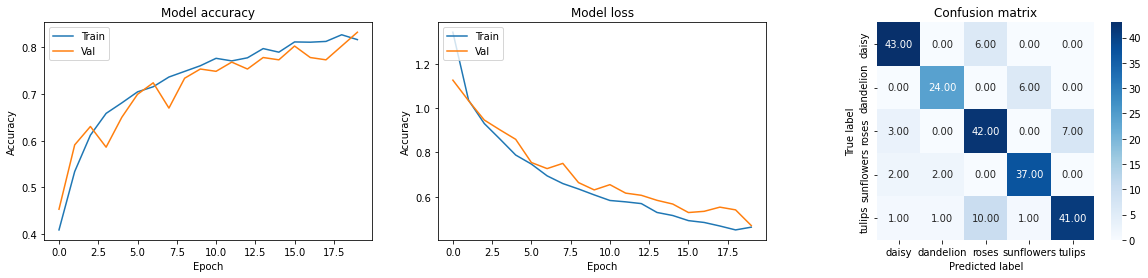

In [16]:
model = train_save_evaluate(model_1, 'models\CNN_01_aug.h5', X_train_aug, y_train_aug, X_val, y_val, X_test, y_test)

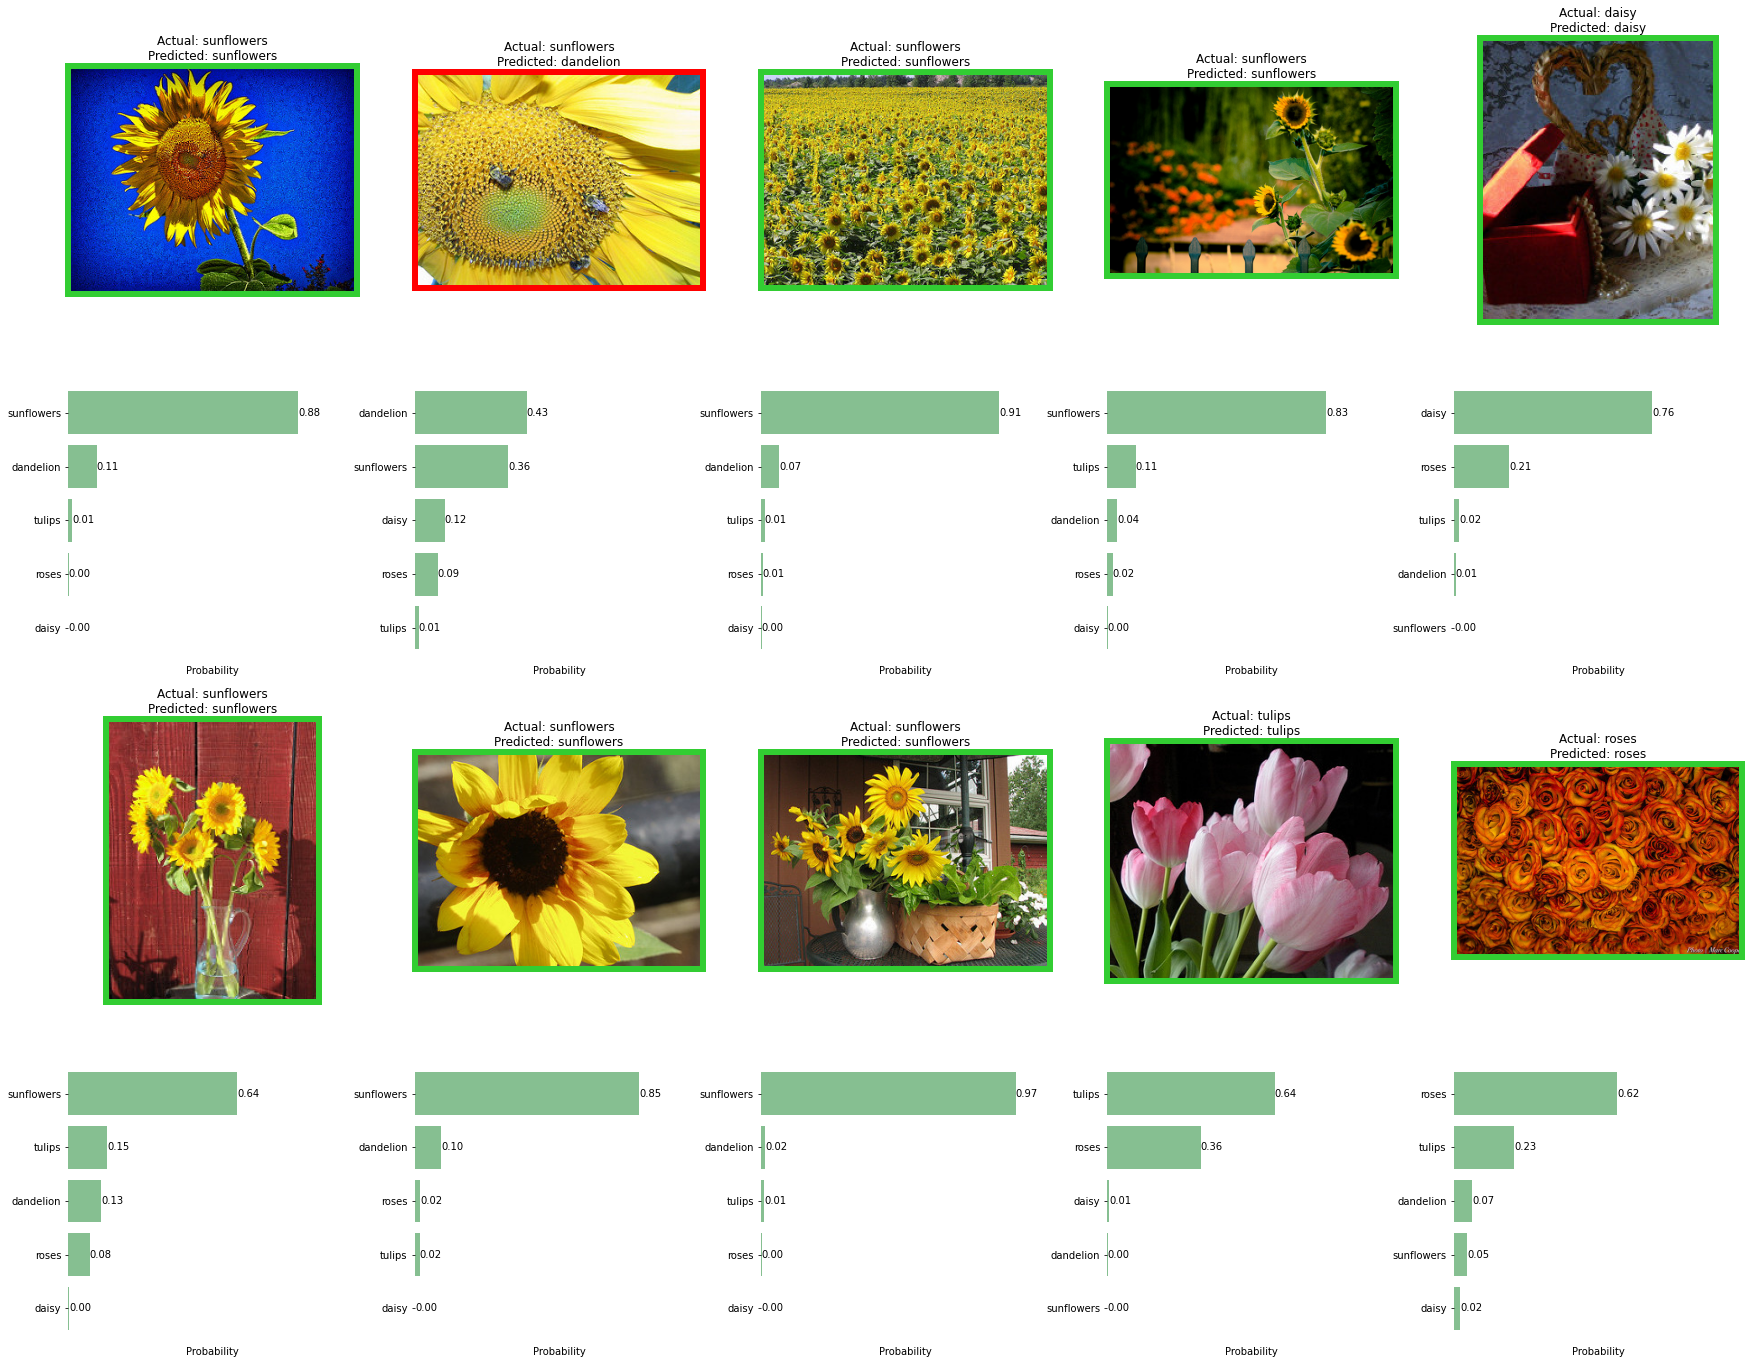

In [17]:
idxs = np.random.randint(0, len(X_init), size=10)
imgs = [X_init[i] for i in idxs]
y_test_imgs = [y_init[i] for i in idxs]
plot_inference(inference_cnn, model, imgs, y_test_imgs, with_prob = True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 128)     3584      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 61, 61, 128)       0         
                                                      

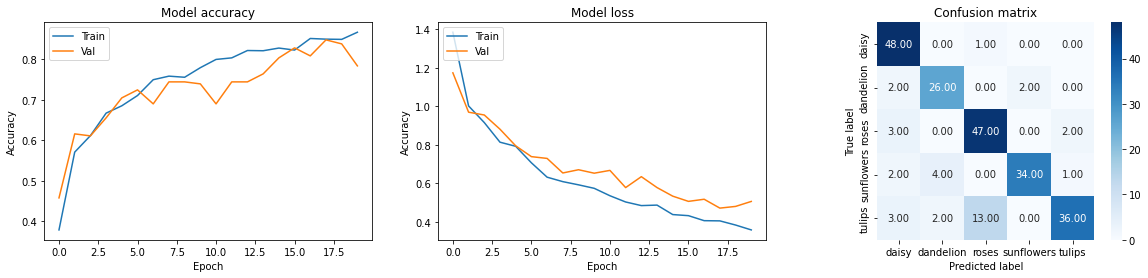

In [18]:
model = train_save_evaluate(model_1, 'models\CNN_01.h5', X_train, y_train, X_val, y_val, X_test, y_test)

In [19]:
def model_2():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(CLASS_NUM,  activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 29, 29, 64)       

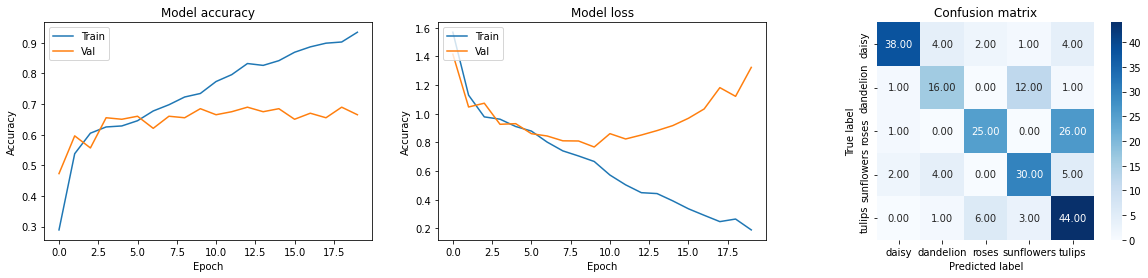

In [20]:
model = train_save_evaluate(model_2, 'models\CNN_02_aug.h5', X_train_aug, y_train_aug, X_val, y_val, X_test, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 29, 29, 64)       

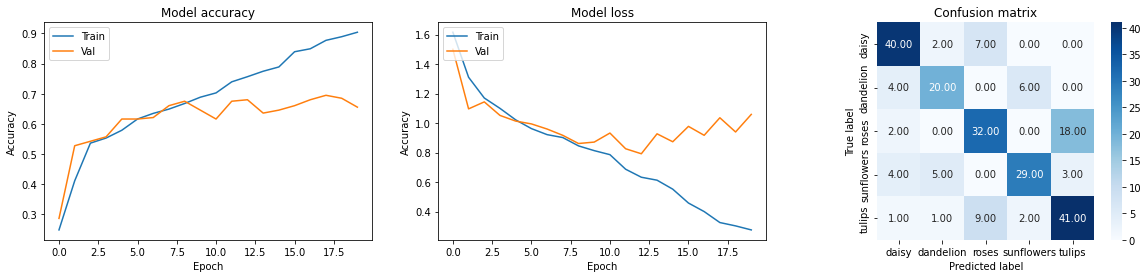

In [21]:
model = train_save_evaluate(model_2, 'models\CNN_02.h5', X_train, y_train, X_val, y_val, X_test, y_test)

## CNN using pretrained model
In this model we have built CNN using some pretrained models such as InceptionV3, DenseNet201.We use all layers except last one and froze their parameters. Then we have added several dense layers and train such models.

In [22]:
dim1 = X_train[0].shape[0] # image width
dim2 = X_train[0].shape[1] # image height 
dim3 = 3 # image channels

In [23]:
from keras.applications.inception_v3 import InceptionV3
def model_3():
    model = InceptionV3(include_top=False, input_shape=(dim1, dim2, dim3))
    model.trainable=False
    flat1 = tf.keras.layers.GlobalAveragePooling2D()(model.layers[-1].output)
    class1 = Dense(10, activation='relu')(flat1)
    output = Dense(5, activation='softmax')(class1)
    model = Model(inputs=model.inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Epoch 1/20
29/29 [==============================] - 30s 875ms/step - loss: 1.3975 - accuracy: 0.3908 - val_loss: 1.0950 - val_accuracy: 0.5271
Epoch 2/20
29/29 [==============================] - 24s 847ms/step - loss: 1.0468 - accuracy: 0.5796 - val_loss: 0.9221 - val_accuracy: 0.6404
Epoch 3/20
29/29 [==============================] - 26s 883ms/step - loss: 0.8441 - accuracy: 0.6872 - val_loss: 0.7701 - val_accuracy: 0.7241
Epoch 4/20
29/29 [==============================] - 25s 863ms/step - loss: 0.6280 - accuracy: 0.7832 - val_loss: 0.6640 - val_accuracy: 0.7586
Epoch 5/20
29/29 [==============================] - 25s 856ms/step - loss: 0.4948 - accuracy: 0.8277 - val_loss: 0.6456 - val_accuracy: 0.7488
Epoch 6/20
29/29 [==============================] - 25s 854ms/step - loss: 0.4144 - accuracy: 0.8661 - val_loss: 0.5866 - val_accuracy: 0.7783
Epoch 7/20
29/29 [==============================] - 25s 864ms/step - loss: 0.3608 - accuracy: 0.8842 - val_loss: 0.5725 - val_accuracy: 0.8079

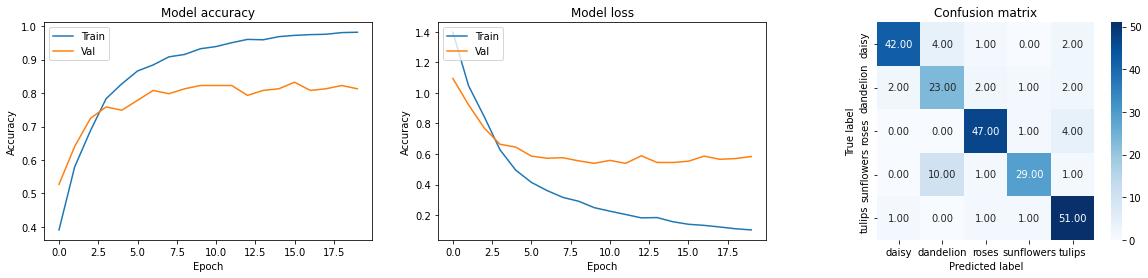

In [24]:
model = train_save_evaluate(model_3, 'models\CNN_03_aug.h5', X_train_aug, y_train_aug, X_val, y_val, X_test, y_test, show_summary = False)

Epoch 1/20
29/29 [==============================] - 31s 902ms/step - loss: 1.4099 - accuracy: 0.4083 - val_loss: 1.1325 - val_accuracy: 0.6207
Epoch 2/20
29/29 [==============================] - 25s 850ms/step - loss: 0.9801 - accuracy: 0.6636 - val_loss: 0.9474 - val_accuracy: 0.7044
Epoch 3/20
29/29 [==============================] - 25s 864ms/step - loss: 0.7881 - accuracy: 0.7228 - val_loss: 0.8132 - val_accuracy: 0.7389
Epoch 4/20
29/29 [==============================] - 25s 864ms/step - loss: 0.6512 - accuracy: 0.7580 - val_loss: 0.7574 - val_accuracy: 0.7438
Epoch 5/20
29/29 [==============================] - 25s 871ms/step - loss: 0.5668 - accuracy: 0.7783 - val_loss: 0.7213 - val_accuracy: 0.7389
Epoch 6/20
29/29 [==============================] - 26s 899ms/step - loss: 0.5013 - accuracy: 0.7942 - val_loss: 0.7071 - val_accuracy: 0.7488
Epoch 7/20
29/29 [==============================] - 25s 864ms/step - loss: 0.4455 - accuracy: 0.8161 - val_loss: 0.7103 - val_accuracy: 0.7438

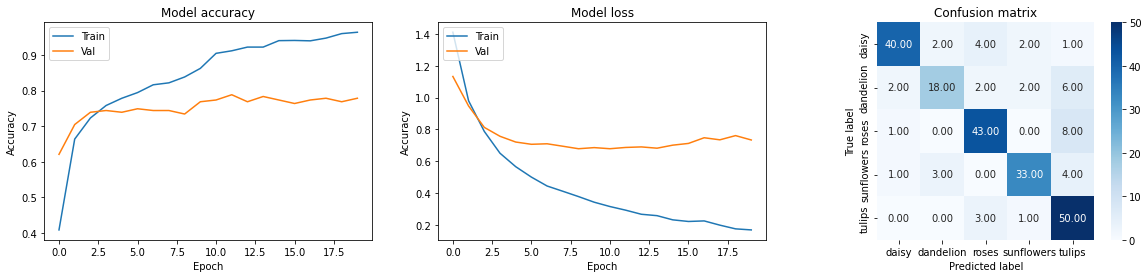

In [25]:
model = train_save_evaluate(model_3, 'models\CNN_03.h5', X_train, y_train, X_val, y_val, X_test, y_test, show_summary = False)

Epoch 1/20
29/29 [==============================] - 156s 5s/step - loss: 1.3072 - accuracy: 0.4978 - val_loss: 0.9000 - val_accuracy: 0.7044
Epoch 2/20
29/29 [==============================] - 142s 5s/step - loss: 0.8339 - accuracy: 0.7234 - val_loss: 0.6182 - val_accuracy: 0.8374
Epoch 3/20
29/29 [==============================] - 147s 5s/step - loss: 0.5687 - accuracy: 0.8430 - val_loss: 0.3909 - val_accuracy: 0.9015
Epoch 4/20
29/29 [==============================] - 143s 5s/step - loss: 0.3834 - accuracy: 0.8902 - val_loss: 0.3034 - val_accuracy: 0.9113
Epoch 5/20
29/29 [==============================] - 144s 5s/step - loss: 0.2910 - accuracy: 0.9221 - val_loss: 0.2705 - val_accuracy: 0.9212
Epoch 6/20
29/29 [==============================] - 144s 5s/step - loss: 0.2432 - accuracy: 0.9319 - val_loss: 0.2394 - val_accuracy: 0.9163
Epoch 7/20
29/29 [==============================] - 143s 5s/step - loss: 0.1995 - accuracy: 0.9490 - val_loss: 0.2220 - val_accuracy: 0.9212
Epoch 8/20
29

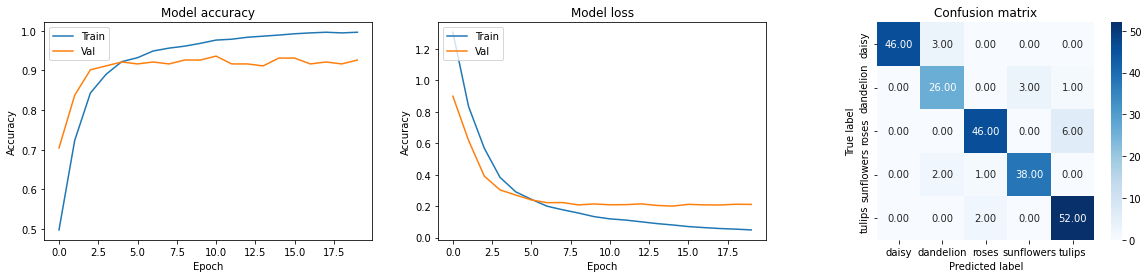

In [27]:
from keras.applications.densenet import DenseNet201
def model_4():
    model = DenseNet201(weights='imagenet', include_top=False, input_shape=(dim1, dim2, dim3))
    #InceptionV3(include_top=False, input_shape=(dim1, dim2, dim3))
    model.trainable=False
    flat1 = tf.keras.layers.GlobalAveragePooling2D()(model.layers[-1].output)
    class1 = Dense(10, activation='relu')(flat1)
    output = Dense(5, activation='softmax')(class1)
    model = Model(inputs=model.inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = train_save_evaluate(model_4, 'models\CNN_04_aug.h5', X_train_aug, y_train_aug, X_val, y_val, X_test, y_test, show_summary = False)

Epoch 1/20
29/29 [==============================] - 175s 6s/step - loss: 1.1525 - accuracy: 0.5565 - val_loss: 0.6947 - val_accuracy: 0.7537
Epoch 2/20
29/29 [==============================] - 160s 6s/step - loss: 0.4936 - accuracy: 0.8353 - val_loss: 0.4005 - val_accuracy: 0.8768
Epoch 3/20
29/29 [==============================] - 160s 6s/step - loss: 0.3175 - accuracy: 0.8979 - val_loss: 0.3044 - val_accuracy: 0.9113
Epoch 4/20
29/29 [==============================] - 161s 6s/step - loss: 0.2371 - accuracy: 0.9303 - val_loss: 0.2703 - val_accuracy: 0.9064
Epoch 5/20
29/29 [==============================] - 161s 6s/step - loss: 0.1925 - accuracy: 0.9440 - val_loss: 0.2547 - val_accuracy: 0.8966
Epoch 6/20
29/29 [==============================] - 164s 6s/step - loss: 0.1555 - accuracy: 0.9588 - val_loss: 0.2211 - val_accuracy: 0.9113
Epoch 7/20
29/29 [==============================] - 161s 6s/step - loss: 0.1332 - accuracy: 0.9676 - val_loss: 0.2201 - val_accuracy: 0.9212
Epoch 8/20
29

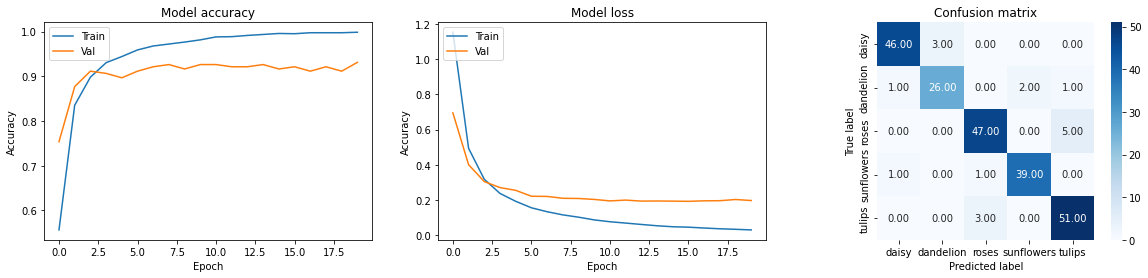

In [28]:
model = train_save_evaluate(model_4, 'models\CNN_04.h5', X_train, y_train, X_val, y_val, X_test, y_test, show_summary = False)

## Best CNN model
The best models are based on DenseNet201 and have accuracy about 90%. Let's upload it and view the results.

In [29]:
path = 'models\CNN_04.h5'
model = tf.keras.models.load_model(path)

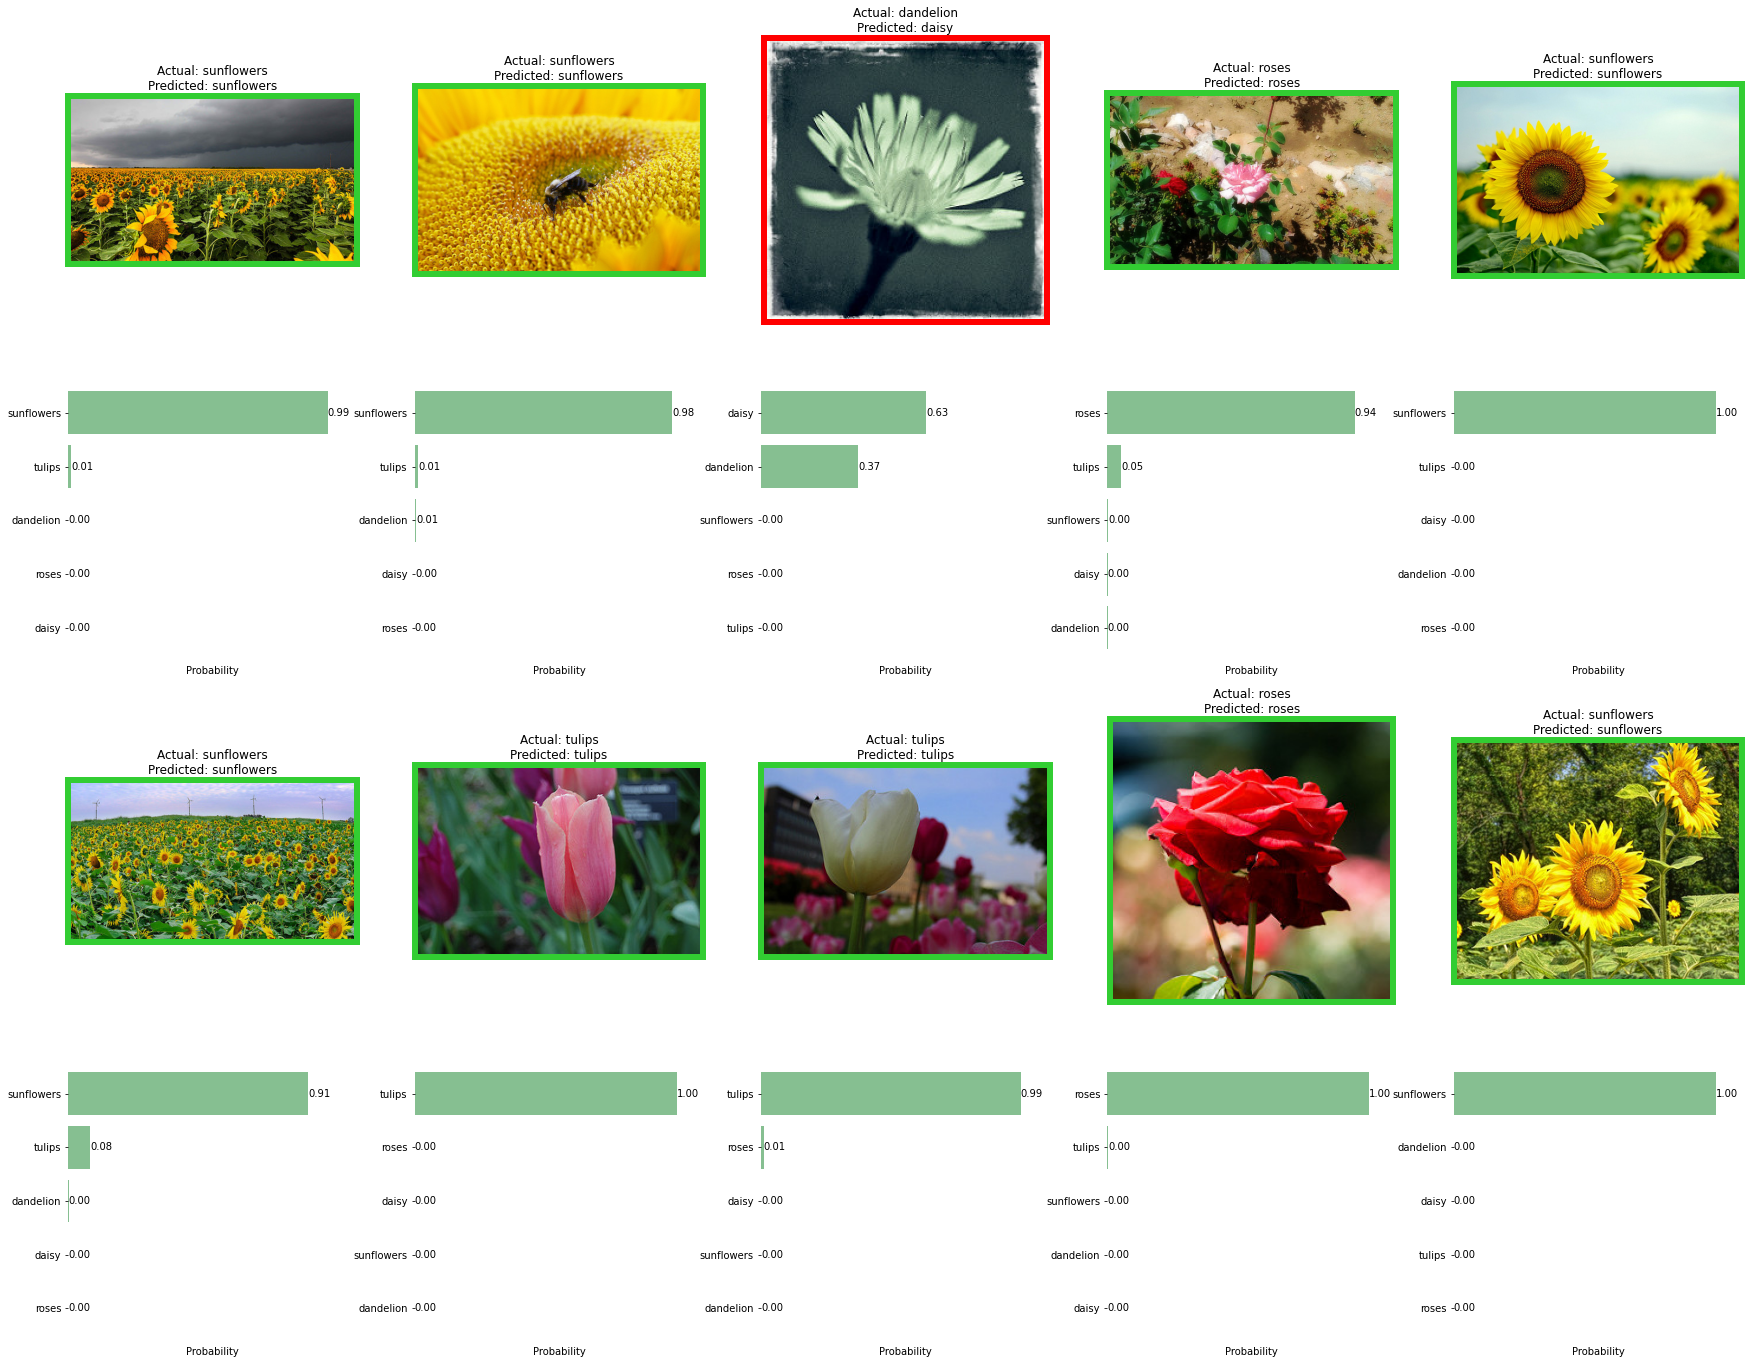

In [30]:
idxs = np.random.randint(0, len(X_init), size=10)
imgs = [X_init[i] for i in idxs]
y_test_imgs = [y_init[i] for i in idxs]
plot_inference(inference_cnn, model, imgs, y_test_imgs, with_prob = True)

## ANN
After investigating different articles I have tried to do something similar but unfortunately the accuracy of models were poor, the best one has only 40% :(

Ideas which I have been trying were:
- use segmentation (with thresholding and finding the biggest area as image), then calculate HOG, mean and std for color channels
- blur images a bit with morphology, then calculate HOG
- using Gabor features

In [15]:
# Image segmented -> color mean, std, hog -> 40%
# Morphology, resize -> hog -> 42%
def model_5():
    model = Sequential()
    #model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add(Dense(32, activation='relu', input_shape=X_train.shape[1:]))
    #model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(CLASS_NUM,  activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

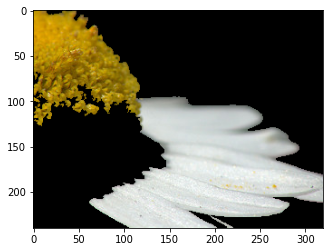

In [16]:
def largest_component_mask(bin_img):
    """Finds the largest component in a binary image and returns the component as a mask."""

    contours = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    # should be [1] if OpenCV 3+

    max_area = 0
    max_contour_index = 0
    for i, contour in enumerate(contours):
        contour_area = cv2.moments(contour)['m00']
        if contour_area > max_area:
            max_area = contour_area
            max_contour_index = i

    labeled_img = np.zeros(bin_img.shape, dtype=np.uint8)
    cv2.drawContours(labeled_img, contours, max_contour_index, color=255, thickness=-1)

    return labeled_img

def segment(image):
    img = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,255,2)
    mask = largest_component_mask(img)
    res = cv2.bitwise_and(image,image,mask = mask)
    return res

img = X_init[200]
res = segment(img)
plt.imshow(res, cmap='gray')

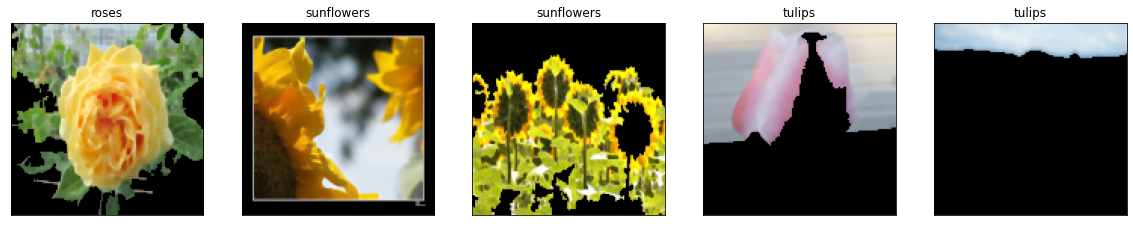

In [17]:
DIM = (128, 128)
def preprocess(X_init):
    X = []
    for i in range(len(X_init)):
        img = X_init[i].copy()
        kernel = np.ones((3,3),np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
        img = cv2.resize(img, DIM, interpolation = cv2.INTER_AREA)
        #img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        img = segment(img)
        X.append(img)
    return X

X = preprocess(X_init)
X = np.array(X)
plot_sample(X, y)

def preprocess(X_init):
    X = []
    hog = cv2.HOGDescriptor()
    for i in range(len(X_init)):
        img = X_init[i].copy()
        h = hog.compute(img)
        color = img.mean(), img.std()
        res = np.concatenate((h, color), axis=None)
        X.append(res)
    return X
X = preprocess(X)
X = np.array(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0) # split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0) # split data
print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 1822
Val size: 203
Test size: 226


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1088736   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,089,957
Trainable params: 1,089,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
29/29 [============================

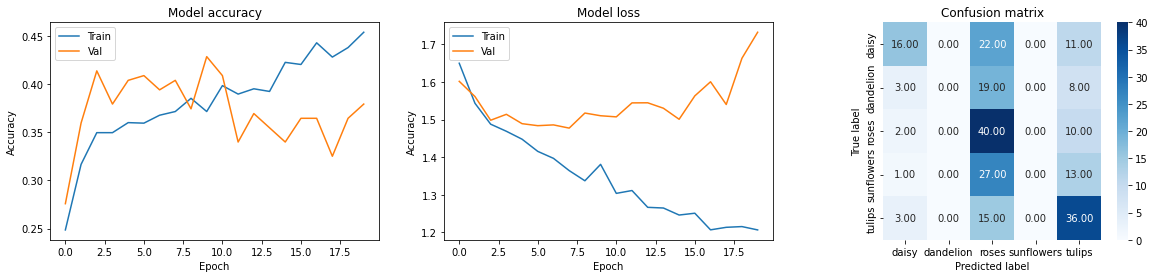

In [19]:
model = train_save_evaluate(model_5, 'models\ANN_01.h5', X_train, y_train, X_val, y_val, X_test, y_test)

## Other snippets
Maybe I will try later to deal with ANN

In [13]:
def preprocess(X_init):
    X = []
    for i in range(len(X_init)):
        img = X_init[i].copy()
        img = cv2.resize(img, DIM, interpolation = cv2.INTER_AREA)
        img = cv2.blur(img,(5,5))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        X.append(img)
    return X

def preprocess(X_init):
    X = []
    for i in range(len(X_init)):
        img = X_init[i].copy()
        #img = cv2.blur(img,(5,5))
        kernel = np.ones((3,3),np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
        img = cv2.resize(img, DIM, interpolation = cv2.INTER_AREA)
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        #img = segment(img)
        X.append(img)
    return X

In [16]:
dim = (128, 128)
def preprocess(X_init):
    X = []
    hog = cv2.HOGDescriptor()
    for i in range(len(X_init)):
        img = X_init[i].copy()
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        #img = cv2.blur(img,(5,5))
        h = hog.compute(img)
        X.append(h)
    return X
X = preprocess(X2)

In [ ]:
def preprocess(X_init):
    X = []
    hog = cv2.HOGDescriptor()
    for i in range(len(X_init)):
        img = X_init[i].copy()
        h = hog.compute(img)
        #color = np.array(img).flatten()
        color = img.mean(), img.std()
        res = np.concatenate((h, color), axis=None)
        X.append(res)
    return X
X = preprocess(X_init)

In [32]:
import cv2
import numpy as np
import pylab as pl
import glob
import pandas as pd

# define gabor filter bank with different orientations and at different scales
def build_filters():
    filters = []
    ksize = 9
    #define the range for theta and nu
    for theta in np.arange(0, np.pi, np.pi / 8):
        for nu in np.arange(0, 6*np.pi/4 , np.pi / 4):
            kern = cv2.getGaborKernel((ksize, ksize), 1.0, theta, nu, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
    return filters

#function to convolve the image with the filters
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

def preprocess_img(img, filters):
    feat = []
    #calculating the local energy for each convolved image
    for j in range(40):
        res = process(img, f[j])
        temp = 0
        for p in range(128):
            for q in range(128):
                temp = temp + res[p][q]*res[p][q]
        feat.append(temp)
    #calculating the mean amplitude for each convolved image
    for j in range(40):
        res = process(img, f[j])
        temp = 0
        for p in range(128):
            for q in range(128):
                temp = temp + abs(res[p][q])
        feat.append(temp)
     #feat matrix is the feature vector for the image
    return feat

filters = build_filters()
f = np.asarray(filters)

#img = cv2.imread(path)
#img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
#feats = preprocess_img(img, f)

In [50]:
dim = (128, 128)
def preprocess(X_init):
    X = []
    filters = build_filters()
    f = np.asarray(filters)
    for i in range(len(X_init)):
        img = X_init[i].copy()
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        feats = preprocess_img(img, f)
        X.append(feats)
    return X
X = preprocess(X_init)